## パネルデータ分析
年ごとの差を比較するので、隠れた変数の効果を消すことができる。
ex)
2011
Y = ax + bx' + c + (dx'') dx''=実際にはない変数
2013
Y = ax + bx' + c + (dx'') 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("http://mcobaya.web.fc2.com/tfr1_long.csv",encoding="shift-jis")

### flp=女性労働力率 tfr=合計特殊出生率

### Entity Effects(individual effects) and Time Effects
entity effect is　観測されない変数によるエフェクト。もし観測されない変数が時間によって不変なら、パネルデータ分析で相殺される。
time effect is 時間によって変わったとされる部分。

In [8]:
df_1980 = df[df['year'] == 1980]
df_2000 = df[df['year'] == 2000]

In [18]:
df

,pref,flp,tfr,year
0,北海道,47.1,1.64,1980
1,青森,53.5,1.85,1980
2,岩手,59.2,1.95,1980
3,宮城,53.3,1.86,1980
4,秋田,59.1,1.79,1980
...,...,...,...,...
89,熊本,62.4,1.56,2000
90,大分,59.6,1.51,2000
91,宮崎,62.9,1.62,2000
92,鹿児島,58.7,1.58,2000


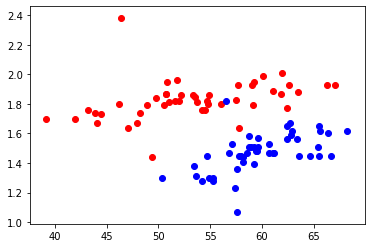

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
x1 = df_1980['flp']
x2 = df_1980['tfr']
x3 = df_2000['flp']
x4 = df_2000['tfr']

ax.scatter(x1, x2, c='red')
ax.scatter(x3, x4, c='blue')

In [17]:
import numpy as np
from scipy.stats import norm, gaussian_kde
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
from collections import OrderedDict
import wooldridge
from statsmodels.formula.api import ols

In [74]:
df.iloc[:47,0]

0     北海道
1      青森
2      岩手
3      宮城
4      秋田
5      山形
6      福島
7      茨城
8      栃木
9      群馬
10     埼玉
11     千葉
12     東京
13    神奈川
14     新潟
15     富山
16     石川
17     福井
18     山梨
19     長野
20     岐阜
21     静岡
22     愛知
23     三重
24     滋賀
25     京都
26     大阪
27     兵庫
28     奈良
29    和歌山
30     鳥取
31     島根
32     岡山
33     広島
34     山口
35     徳島
36     香川
37     愛媛
38     高知
39     福岡
40     佐賀
41     長崎
42     熊本
43     大分
44     宮崎
45    鹿児島
46     沖縄
Name: pref, dtype: object

In [77]:
df.iloc[:47,0] = [i for i in range(0,47)]
df.iloc[47:, 0] = [i for i in range(0,47)]

In [78]:
df_main = df.reindex(['year','pref', 'flp', 'tfr'], axis='columns')
df_main.set_index(['year', 'pref'],inplace=True, drop=False)
df_main
#indexは二つ必要。比較する用(year)とカテゴリー(pref)

year  pref   flp   tfr
year pref                        
1980 0     1980     0  47.1  1.64
     1     1980     1  53.5  1.85
     2     1980     2  59.2  1.95
     3     1980     3  53.3  1.86
     4     1980     4  59.1  1.79
...         ...   ...   ...   ...
2000 42    2000    42  62.4  1.56
     43    2000    43  59.6  1.51
     44    2000    44  62.9  1.62
     45    2000    45  58.7  1.58
     46    2000    46  56.5  1.82

[94 rows x 4 columns]

In [79]:
df_panel = PanelData(df_main)
df_panel

PanelData
             year  pref   flp   tfr
year pref                          
1980 0     1980.0   0.0  47.1  1.64
     1     1980.0   1.0  53.5  1.85
     2     1980.0   2.0  59.2  1.95
     3     1980.0   3.0  53.3  1.86
     4     1980.0   4.0  59.1  1.79
...           ...   ...   ...   ...
2000 42    2000.0  42.0  62.4  1.56
     43    2000.0  43.0  59.6  1.51
     44    2000.0  44.0  62.9  1.62
     45    2000.0  45.0  58.7  1.58
     46    2000.0  46.0  56.5  1.82

[94 rows x 4 columns]
PanelData object, id: 0x2b13785e128

In [52]:
(~df_panel.isnull).all()

True

In [86]:
formula_fe = 'tfr ~ flp \
                      + EntityEffects'
formula_fe2 = 'tfr ~ flp \
                      + EntityEffects + TimeEffects'
# \で改行
#'lwage ~ married + union + expersq + TimeEffects + EntityEffects'

In [85]:
mod_fe = PanelOLS.from_formula(formula_fe, data=df_panel)
result_fe = mod_fe.fit()
print(result_fe.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
flp            0.0102     0.0023     4.3819     0.0000      0.0056      0.0148


In [87]:
mod_fe = PanelOLS.from_formula(formula_fe2, data=df_panel)
result_fe = mod_fe.fit()
print(result_fe.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
flp           -0.0096     0.0029    -3.3297     0.0017     -0.0154     -0.0038


### Time effects をいれるということは前の式に1980=0 or 1というダミー変数を追加していることと同義
#### 上の式に46このダミー変数を追加して都道府県を変数に入れることもできる。